marketing_df : bank client data: 
https://www.kaggle.com/datasets/adityamhaske/bank-marketing-dataset?resource=download

1 - age (numeric)

2 - job : type of job (categorical:
"admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

* ##### related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

* ##### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

* ##### Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None



In [123]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import functions

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


df_uci_clean = pd.read_csv("../data/clean/load_and_clean_uci_data_davy.csv")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df_uci_clean.info()
df_uci_clean.head()

<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            45211 non-null  int64
 1   job_type                       45211 non-null  str  
 2   marital_status                 45211 non-null  str  
 3   education_level                45211 non-null  str  
 4   credit_default                 45211 non-null  str  
 5   account_balance                45211 non-null  int64
 6   housing_loan                   45211 non-null  str  
 7   personal_loan                  45211 non-null  str  
 8   contact_type                   45211 non-null  str  
 9   contact_day                    45211 non-null  int64
 10  contact_month                  45211 non-null  str  
 11  call_duration_sec              45211 non-null  int64
 12  num_contacts_current_campaign  45211 non-null  int64
 13  days_since_last_contact    

,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,contact_month,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,56-65,1 contact,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,36-45,1 contact,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,26-35,1 contact,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,46-55,1 contact,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,26-35,1 contact,0


In [7]:
df_uci_clean.campaign_group.unique()

<StringArray>
['1 contact', '2–3 contacts', '4–5 contacts', '6–10 contacts', '10+ contacts']
Length: 5, dtype: str

# EDA


[1] Target distribution
What: Distribution of the target variable.
Why: To check for class imbalance and understand baseline conversion rates.



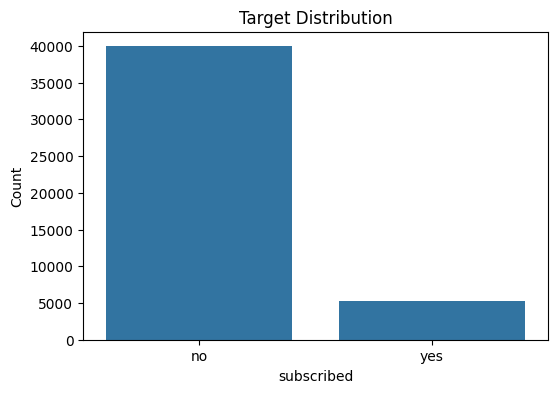


[2] Numeric feature distributions
What: Histograms of numeric variables.
Why: To detect skewness, outliers, and typical value ranges,
     which influence scaling choices and model robustness.



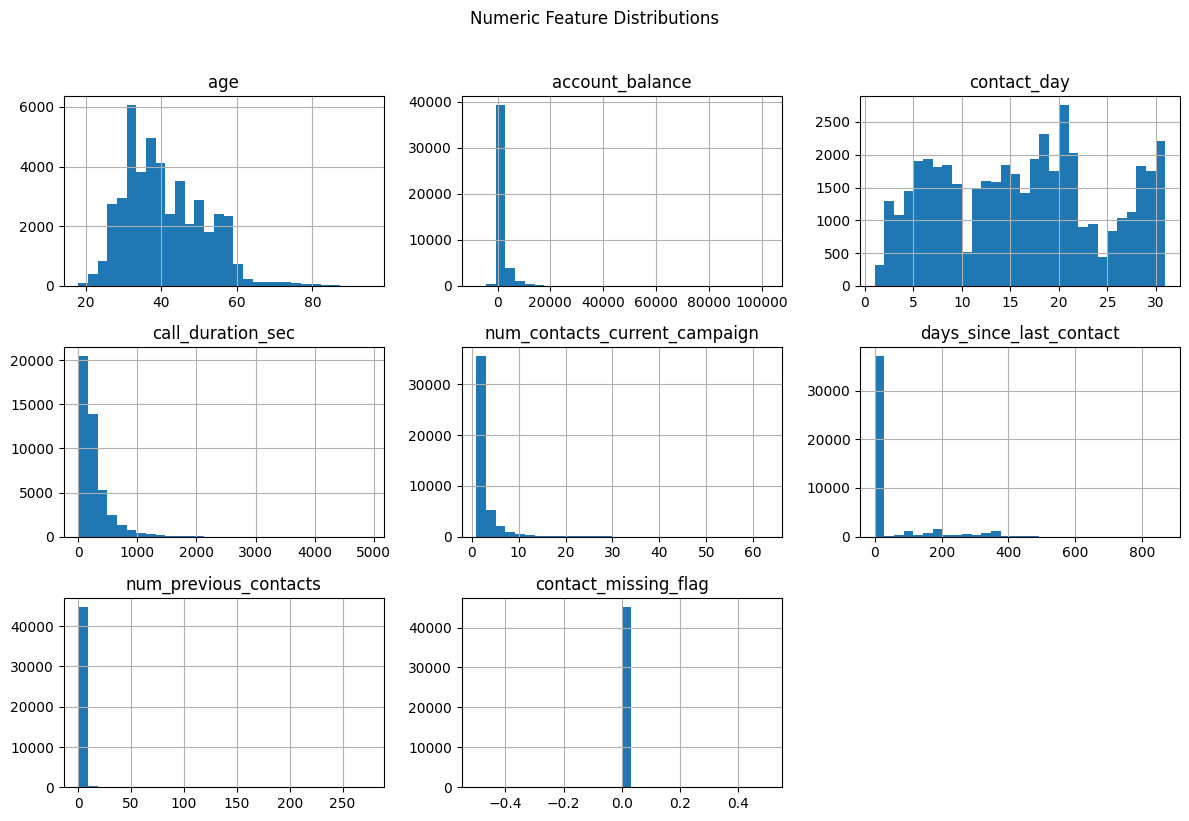


[5] Correlation matrix of numeric features
What: Correlation heatmap of numeric variables.
Why: To understand relationships between features and with the target,
     and to detect potential multicollinearity before modeling.



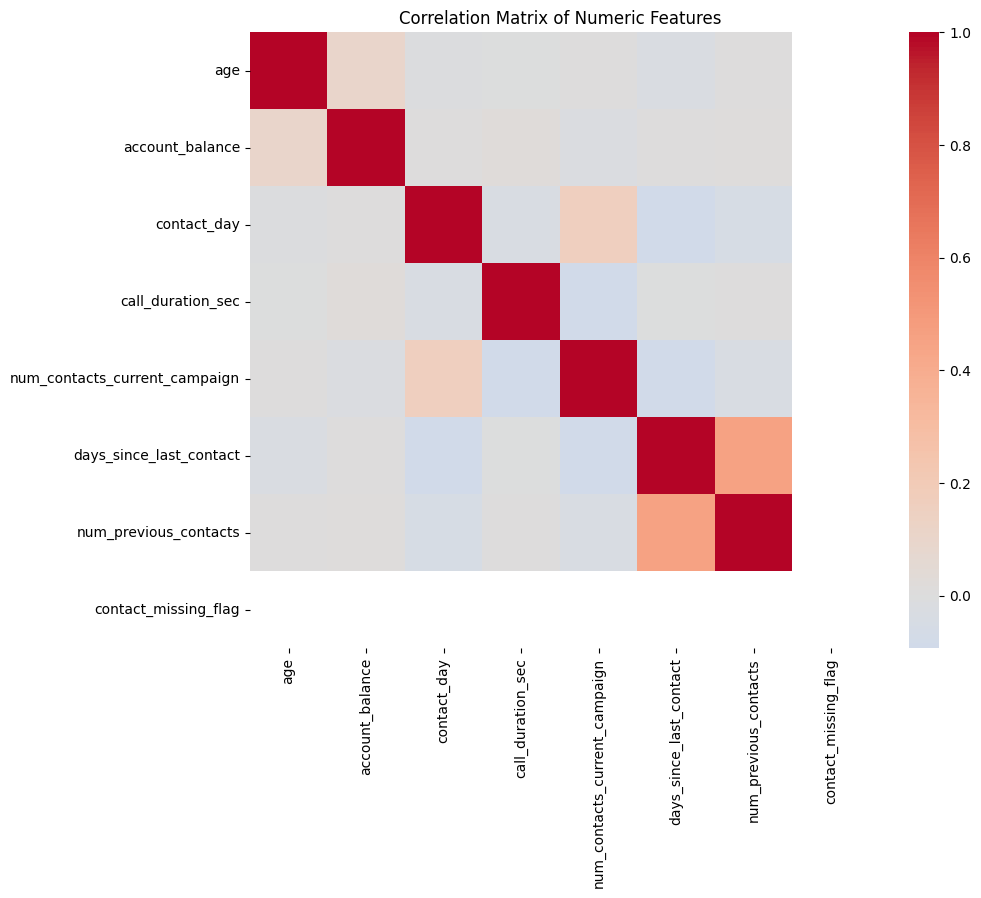

In [8]:
from functions import eda_uci_dataset
eda_uci_dataset(df_uci_clean, target_col='subscribed')

## H1 — Customers who show stronger engagement (fewer repeated contacts, longer call duration) are more likely to subscribe.

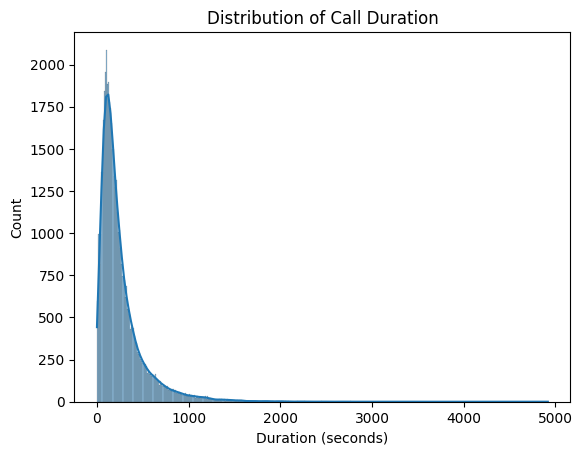

In [10]:
### Distribution of call duration
sns.histplot(df_uci_clean['call_duration_sec'], kde=True)
plt.title("Distribution of Call Duration")
plt.xlabel("Duration (seconds)")
plt.show()


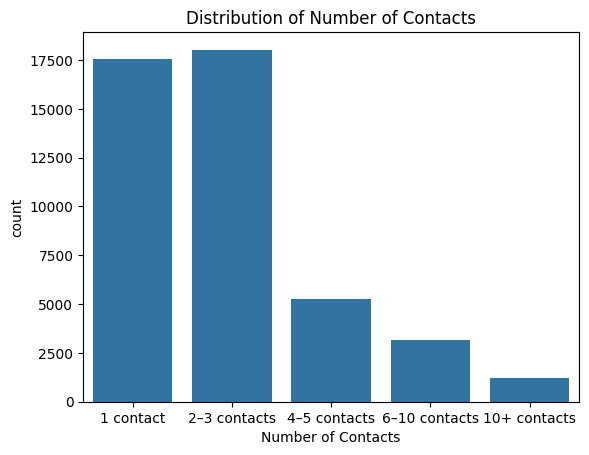

In [11]:
### Distribution of number of contacts
sns.countplot(x='campaign_group', data=df_uci_clean)
plt.title("Distribution of Number of Contacts")
plt.xlabel("Number of Contacts")
plt.show()


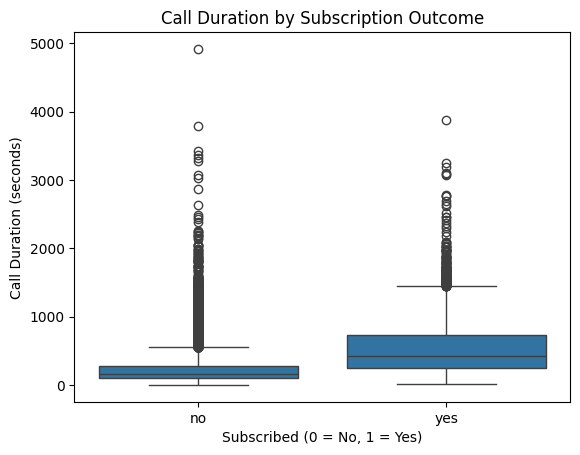

In [12]:
### Call Duration vs Subscription (Boxplot + Stats)
sns.boxplot(x='subscribed', y='call_duration_sec', data=df_uci_clean)
plt.title("Call Duration by Subscription Outcome")
plt.xlabel("Subscribed (0 = No, 1 = Yes)")
plt.ylabel("Call Duration (seconds)")
plt.show()


In [13]:
df_uci_clean['subscribed'].value_counts()


subscribed
no     39922
yes     5289
Name: count, dtype: int64

In [18]:
df_uci_clean.head()

,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,contact_month,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,56-65,1 contact,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,36-45,1 contact,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,26-35,1 contact,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,46-55,1 contact,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,26-35,1 contact,0


In [19]:
df_uci_clean.columns

Index(['age', 'job_type', 'marital_status', 'education_level',
       'credit_default', 'account_balance', 'housing_loan', 'personal_loan',
       'contact_type', 'contact_day', 'contact_month', 'call_duration_sec',
       'num_contacts_current_campaign', 'days_since_last_contact',
       'num_previous_contacts', 'previous_outcome', 'subscribed',
       'age_group_bin', 'campaign_group', 'contact_missing_flag'],
      dtype='str')

In [20]:
group_yes = df_uci_clean[df_uci_clean['subscribed'] == 1]['call_duration_sec']
group_no = df_uci_clean[df_uci_clean['subscribed'] == 0]['call_duration_sec']

In [21]:
group_yes.head()
group_no.head()

Series([], Name: call_duration_sec, dtype: int64)

In [23]:
if len(group_yes) >= 10 and len(group_no) >= 10:
    stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')
    print("Mann-Whitney U p-value:", p)
else:
    print("Sample size too small for reliable Mann-Whitney U test.")


Sample size too small for reliable Mann-Whitney U test.


In [24]:
df_uci_clean = df_uci_clean[df_uci_clean['call_duration_sec'] > 300]
df_uci_clean

,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,contact_month,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no,36-45,1 contact,0
12,53,technician,married,secondary,no,6,yes,no,unknown,5,may,517,1,-1,0,unknown,no,46-55,1 contact,0
15,51,retired,married,primary,no,229,yes,no,unknown,5,may,353,1,-1,0,unknown,no,46-55,1 contact,0
23,25,services,married,secondary,no,50,yes,no,unknown,5,may,342,1,-1,0,unknown,no,18-25,1 contact,0
29,36,technician,single,secondary,no,265,yes,yes,unknown,5,may,348,1,-1,0,unknown,no,36-45,1 contact,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,46-55,2–3 contacts,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,65+,2–3 contacts,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,65+,4–5 contacts,0
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,56-65,4–5 contacts,0


In [25]:
df_uci_clean['subscribed'].value_counts()



subscribed
no     8816
yes    3458
Name: count, dtype: int64

In [26]:
df_uci_clean['subscribed'].value_counts(normalize=True)


subscribed
no     0.718266
yes    0.281734
Name: proportion, dtype: float64

In [27]:
### Statistical test: Mann‑Whitney U (non‑normal distributions)
from scipy.stats import mannwhitneyu

group_yes = df_uci_clean[df_uci_clean['subscribed']==1]['call_duration_sec']
group_no  = df_uci_clean[df_uci_clean['subscribed']==0]['call_duration_sec']

stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')
print("Mann-Whitney U p-value:", p)


Mann-Whitney U p-value: nan


C:\Users\davyg\AppData\Local\Temp\ipykernel_22800\530433412.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')


B. Number of Contacts vs Subscription

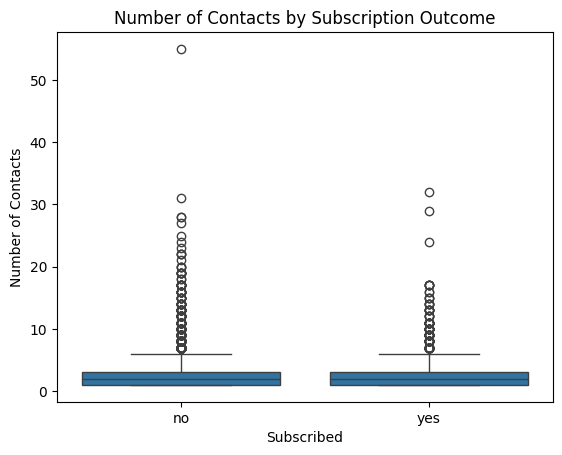

In [28]:
sns.boxplot(x='subscribed', y='num_contacts_current_campaign', data=df_uci_clean)
plt.title("Number of Contacts by Subscription Outcome")
plt.xlabel("Subscribed")
plt.ylabel("Number of Contacts")
plt.show()


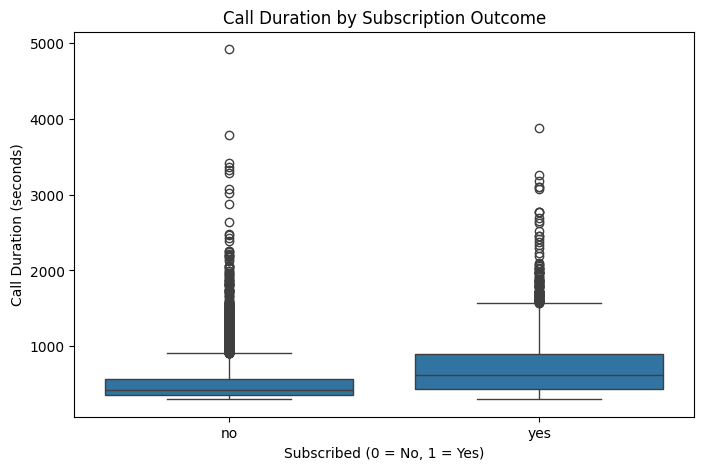

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Duration vs Subscription
plt.figure(figsize=(8,5))
sns.boxplot(x=df_uci_clean['subscribed'], y=df_uci_clean['call_duration_sec'])
plt.title("Call Duration by Subscription Outcome")
plt.xlabel("Subscribed (0 = No, 1 = Yes)")
plt.ylabel("Call Duration (seconds)")
plt.show()


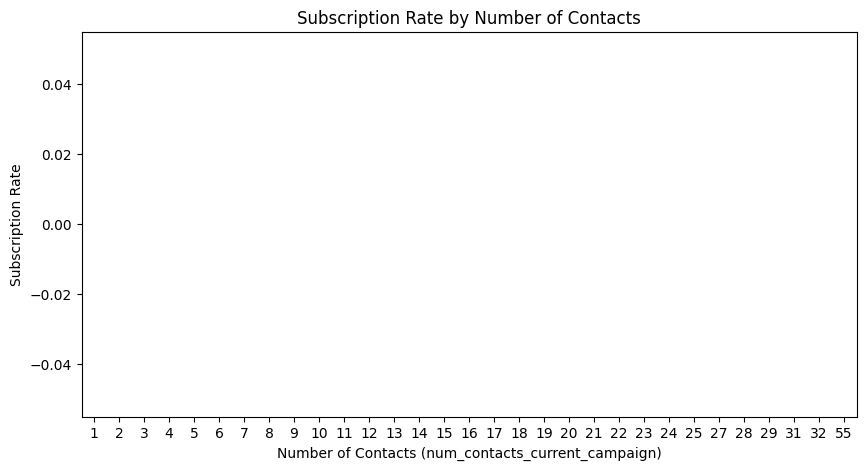

In [35]:
# Bar Chart: Subscription Rate by Number of Contacts (num_contacts_current_campaign)

df_uci_clean['subscribed']= df_uci_clean['subscribed'].map({'no': 0, 'yes': 1})

campaign_rate = df_uci_clean.groupby('num_contacts_current_campaign')['subscribed'].mean().reset_index()


plt.figure(figsize=(10,5))
sns.barplot(data=campaign_rate, x='num_contacts_current_campaign', y='subscribed')
plt.title("Subscription Rate by Number of Contacts")
plt.xlabel("Number of Contacts (num_contacts_current_campaign)")
plt.ylabel("Subscription Rate")
plt.show()


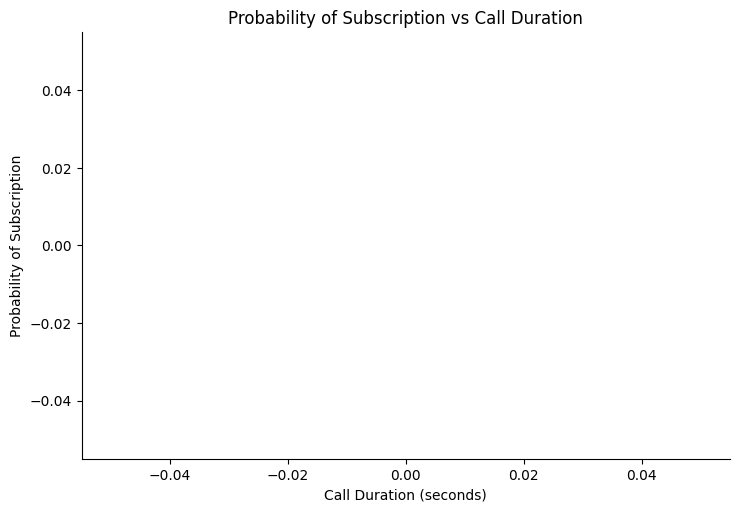

In [43]:
# Scatterplot with Trendline: Duration vs Probability of Subscription
sns.lmplot(data=df_uci_clean, x='call_duration_sec', y='subscribed', logistic=True, height=5, aspect=1.5)
plt.title("Probability of Subscription vs Call Duration")
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Probability of Subscription")
plt.show()


In [45]:
df_uci_clean['contact_type'].value_counts()

contact_type
cellular     8217
unknown      3399
telephone     658
Name: count, dtype: int64

In [ ]:
df_uci_clean

In [46]:
df_uci_clean[df_uci_clean['contact_type'] == 'telephone'].sort_values(by='num_contacts_current_campaign', ascending=False).head()


,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,contact_month,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag
14008,53,entrepreneur,married,secondary,no,0,yes,no,telephone,10,jul,311,27,-1,0,unknown,NaN,46-55,10+ contacts,0
22306,55,blue-collar,married,primary,no,2384,no,yes,telephone,21,aug,331,20,-1,0,unknown,NaN,46-55,10+ contacts,0
18774,60,retired,married,secondary,no,0,no,no,telephone,31,jul,576,20,-1,0,unknown,NaN,56-65,10+ contacts,0
18284,42,self-employed,married,tertiary,no,0,yes,no,telephone,31,jul,650,19,-1,0,unknown,NaN,36-45,10+ contacts,0
18640,32,blue-collar,married,primary,no,-105,yes,yes,telephone,31,jul,454,19,-1,0,unknown,NaN,26-35,10+ contacts,0


In [47]:
df_uci_clean[df_uci_clean['contact_type'] == 'telephone'].sort_values(by='num_contacts_current_campaign', ascending=False).head()


,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,contact_month,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag
14008,53,entrepreneur,married,secondary,no,0,yes,no,telephone,10,jul,311,27,-1,0,unknown,NaN,46-55,10+ contacts,0
22306,55,blue-collar,married,primary,no,2384,no,yes,telephone,21,aug,331,20,-1,0,unknown,NaN,46-55,10+ contacts,0
18774,60,retired,married,secondary,no,0,no,no,telephone,31,jul,576,20,-1,0,unknown,NaN,56-65,10+ contacts,0
18284,42,self-employed,married,tertiary,no,0,yes,no,telephone,31,jul,650,19,-1,0,unknown,NaN,36-45,10+ contacts,0
18640,32,blue-collar,married,primary,no,-105,yes,yes,telephone,31,jul,454,19,-1,0,unknown,NaN,26-35,10+ contacts,0


In [49]:
df_uci_clean[df_uci_clean['contact_type'] == 'cellular'].value_counts()

Series([], Name: count, dtype: int64)

# 1.3. Feature Engineering

In [50]:
df_uci_clean = pd.read_csv("../data/clean/load_and_clean_uci_data_davy.csv")

In [51]:
df_uci_clean['duration_group'] = pd.cut(
    df_uci_clean['call_duration_sec'],
    bins=[0, 60, 180, 600, 1800, df_uci_clean['call_duration_sec'].max()],
    labels=['<1 min', '1–3 min', '3–10 min', '10–30 min', '30+ min']
)
df_uci_clean

,age,job_type,marital_status,education_level,credit_default,account_balance,housing_loan,personal_loan,contact_type,contact_day,...,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,previous_outcome,subscribed,age_group_bin,campaign_group,contact_missing_flag,duration_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,56-65,1 contact,0,3–10 min
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,36-45,1 contact,0,1–3 min
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,26-35,1 contact,0,1–3 min
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,46-55,1 contact,0,1–3 min
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,26-35,1 contact,0,3–10 min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,977,3,-1,0,unknown,yes,46-55,2–3 contacts,0,10–30 min
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,456,2,-1,0,unknown,yes,65+,2–3 contacts,0,3–10 min
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,1127,5,184,3,success,yes,65+,4–5 contacts,0,10–30 min
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,508,4,-1,0,unknown,no,56-65,4–5 contacts,0,3–10 min


In [52]:
df_uci_clean.info()

<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            45211 non-null  int64   
 1   job_type                       45211 non-null  str     
 2   marital_status                 45211 non-null  str     
 3   education_level                45211 non-null  str     
 4   credit_default                 45211 non-null  str     
 5   account_balance                45211 non-null  int64   
 6   housing_loan                   45211 non-null  str     
 7   personal_loan                  45211 non-null  str     
 8   contact_type                   45211 non-null  str     
 9   contact_day                    45211 non-null  int64   
 10  contact_month                  45211 non-null  str     
 11  call_duration_sec              45211 non-null  int64   
 12  num_contacts_current_campaign  45211 non-nu

## * H1: Can we predict whether a client will subscribe to a term deposit based on their profile and campaign data?

Our goal is to build a model that helps the marketing team target the right clients.

Steps :
First, we define our features and target. In our case, the target is 'y', which is categorical. This determines the type of machine learning model we use — supervised classification.

### Preprocessing: Encode + Scale + Concatenate

In [103]:
y_train = y_train.map({'no': 0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})



In [104]:
# 2. Separate features and target
X = df_uci_clean.drop(columns=['subscribed', 'contact_day', 'credit_default', 'contact_type'])
y = df_uci_clean['subscribed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [105]:
    # 3. Identify column types
categorical_cols = X.select_dtypes(include=['str', 'object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", len(categorical_cols))
print(categorical_cols)
print("\nNumeric columns:", len(numeric_cols))
print(numerical_cols)


Categorical columns: 10
['job_type', 'marital_status', 'education_level', 'housing_loan', 'personal_loan', 'contact_month', 'previous_outcome', 'age_group_bin', 'campaign_group', 'duration_group']

Numeric columns: 7
['age', 'account_balance', 'call_duration_sec', 'num_contacts_current_campaign', 'days_since_last_contact', 'num_previous_contacts', 'contact_missing_flag']


In [106]:
X.info()

<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            45211 non-null  int64   
 1   job_type                       45211 non-null  str     
 2   marital_status                 45211 non-null  str     
 3   education_level                45211 non-null  str     
 4   account_balance                45211 non-null  int64   
 5   housing_loan                   45211 non-null  str     
 6   personal_loan                  45211 non-null  str     
 7   contact_month                  45211 non-null  str     
 8   call_duration_sec              45211 non-null  int64   
 9   num_contacts_current_campaign  45211 non-null  int64   
 10  days_since_last_contact        45211 non-null  int64   
 11  num_previous_contacts          45211 non-null  int64   
 12  previous_outcome               45211 non-nu

#### Encode categorical features to transform them in numerical columns

In [107]:
# ask to give a numpy array instead of sparse
ohe = OneHotEncoder(sparse_output=False, drop='first') # To avoid having an sparse_matrix as output
ohe.fit(X_train[categorical_cols]) # The .fit() method determines the unique values of each column

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",'first'
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",False
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'error'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"max_ca

In [108]:
# Transform train and test sets
X_train_trans_np = ohe.transform(X_train[categorical_cols])
X_test_trans_np = ohe.transform(X_test[categorical_cols])
X_test_trans_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(9043, 46))

In [109]:
# Convert to DataFrames
X_train_trans_df = pd.DataFrame(X_train_trans_np, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_trans_df = pd.DataFrame(X_test_trans_np, columns=ohe.get_feature_names_out(), index=X_test.index)
X_train_trans_df

,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,job_type_unemployed,...,age_group_bin_65+,campaign_group_10+ contacts,campaign_group_2–3 contacts,campaign_group_4–5 contacts,campaign_group_6–10 contacts,duration_group_1–3 min,duration_group_30+ min,duration_group_3–10 min,duration_group_<1 min,duration_group_nan
13932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4124,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30403,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21243,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42613,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43567,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Scale numerical features to Normalize numeric features

In [110]:
available_numerical_cols = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
scaler.fit(X_train[available_numerical_cols])

# Transform train and test sets
X_train_scaled_np = scaler.transform(X_train[available_numerical_cols])
X_test_scaled_np  = scaler.transform(X_test[available_numerical_cols])

# Convert to DataFrames
X_train_standarized = pd.DataFrame(X_train_scaled_np, columns=scaler.get_feature_names_out(), index=X_train.index)
X_test_standarized  = pd.DataFrame(X_test_scaled_np, columns=scaler.get_feature_names_out(), index=X_test.index)
X_test_standarized

,age,account_balance,call_duration_sec,num_contacts_current_campaign,days_since_last_contact,num_previous_contacts,contact_missing_flag
14001,-0.369597,0.010023,-0.646947,3.961971,-0.410222,-0.241405,0.0
32046,-0.463830,-0.527143,3.162980,-0.567836,-0.410222,-0.241405,0.0
13318,0.572732,-0.576772,-0.057223,0.726394,-0.410222,-0.241405,0.0
42991,1.515061,-0.282564,-0.592630,1.373510,1.481629,0.585721,0.0
14237,-0.746529,-0.576772,0.288076,-0.244279,-0.410222,-0.241405,0.0
...,...,...,...,...,...,...,...
18448,1.138129,-0.363333,1.820582,0.402837,-0.410222,-0.241405,0.0
6654,-1.217694,0.202377,-0.786618,-0.567836,-0.410222,-0.241405,0.0
17106,-1.217694,-0.442805,-0.806017,0.079279,-0.410222,-0.241405,0.0
9025,1.703527,-0.445076,2.150362,-0.567836,-0.410222,-0.241405,0.0


#### Concatenate transformed features

In [111]:
# Final model-ready datasets
X_train_full = pd.concat([X_train_standarized,X_train_trans_df], axis=1)
X_test_full = pd.concat([X_test_standarized,X_test_trans_df], axis=1)

### Train and evaluate baseline model on our dataset

Logistic Regression (baseline)

In [112]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_full, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test_full)
y_proba = log_reg_model.predict_proba(X_test_full)[:, 1]



📊 Logistic Regression Evaluation (Threshold = 0.5):
----------------------------------------
Accuracy      : 0.90
Precision     : 0.62
Recall        : 0.37
F1 Score      : 0.46
AUC (ROC)     : 0.90


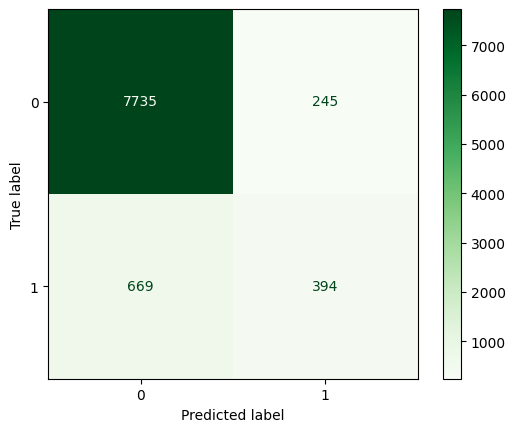

In [114]:
from functions import evaluate_model

y_train = y_train.map({'no': 0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})


evaluate_model(
    model=log_reg_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Logistic Regression Evaluation"
)



📊 Logistic Regression (Threshold = 0.3) (Threshold = 0.3):
----------------------------------------
Accuracy      : 0.89
Precision     : 0.53
Recall        : 0.55
F1 Score      : 0.54
AUC (ROC)     : 0.90


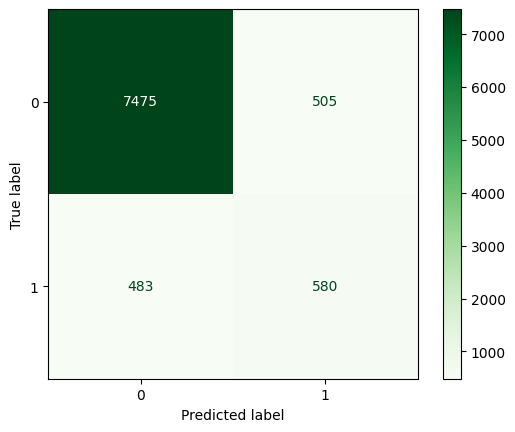

In [115]:
from functions import evaluate_model
# Logistic Regression Evaluation (Threshold = 0.3)
evaluate_model(
    model=log_reg_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.3,
    title="Logistic Regression (Threshold = 0.3)"
)


### Logistic Regression With class weighting:


📊 Logistic Regression balanced Evaluation (Threshold = 0.5):
----------------------------------------
Accuracy      : 0.83
Precision     : 0.39
Recall        : 0.81
F1 Score      : 0.53
AUC (ROC)     : 0.90


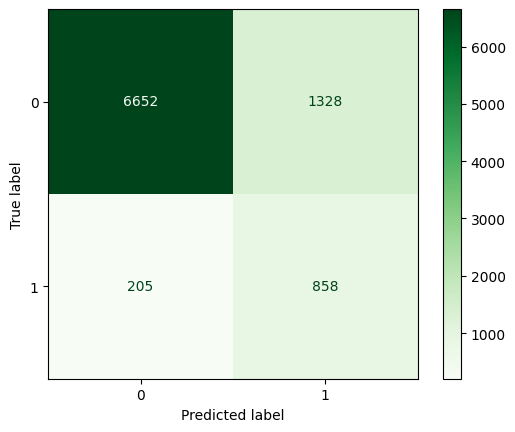

In [116]:
from sklearn.linear_model import LogisticRegression
from functions import classification_diagnostic_plot, evaluate_model

# 1. Train on preprocessed features
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg_balanced.fit(X_train_full, y_train)

# 2. Evaluate on preprocessed test features
evaluate_model(
    model=log_reg_balanced,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Logistic Regression balanced Evaluation"
)


### Interpretations:





517 false negatives, are actual subscribers that the model failed to identify
471 true positives means that the model correctly predicted subscribers
442 false positives, when the model predicted “yes” but actually “no”

### Train a Random Forest baseline

In [117]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=0)
rf_model.fit(X_train_full, y_train)

# Predictions
y_pred = rf_model.predict(X_test_full)
y_proba = rf_model.predict_proba(X_test_full)[:, 1]


📊 Random Forest Evaluation (Threshold = 0.5):
----------------------------------------
Accuracy      : 0.90
Precision     : 0.64
Recall        : 0.37
F1 Score      : 0.46
AUC (ROC)     : 0.91


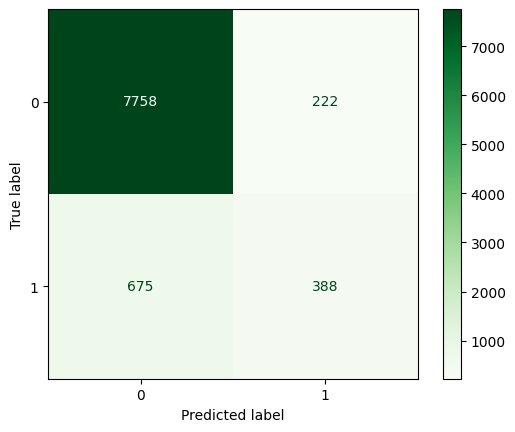

In [118]:
from functions import evaluate_model
evaluate_model(
    model=rf_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Random Forest Evaluation"
)


### We  Train Random Forest on SMOTE‑balanced data  - hyperparameter
it means to create a synthetic examples rather than duplicating or deleting (as oversample or undersample do)

In [119]:
from imblearn.over_sampling import SMOTE
#  Apply SMOTE to the training data
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train_full, y_train) # X_train_sm → oversampled feature matrix and y_train_sm → oversampled target vector

rf_smote_model = RandomForestClassifier(n_estimators=300, random_state=0) 
rf_smote_model.fit(X_train_sm, y_train_sm)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric


📊 Random Forest + SMOTE Evaluation (Threshold = 0.5):
----------------------------------------
Accuracy      : 0.89
Precision     : 0.54
Recall        : 0.54
F1 Score      : 0.54
AUC (ROC)     : 0.91


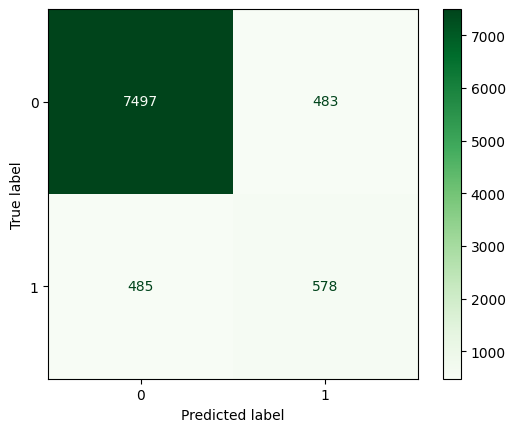

In [120]:
from functions import evaluate_model
evaluate_model(
    model=rf_smote_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Random Forest + SMOTE Evaluation"
)


# XGBoost (with scale_pos_weight)

In [121]:
from xgboost import XGBClassifier

# Estimate class imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb_model.fit(X_train_full, y_train)


C:\Users\davyg\projects_ironhack_2025\week8\final_project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:45:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 


📊 XGBoost Evaluation (Threshold = 0.5):
----------------------------------------
Accuracy      : 0.85
Precision     : 0.43
Recall        : 0.80
F1 Score      : 0.56
AUC (ROC)     : 0.91


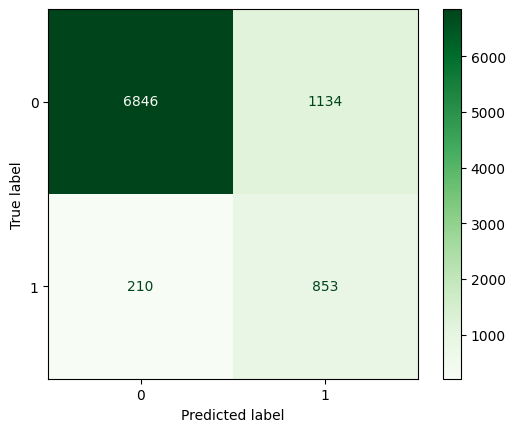

In [122]:
from functions import evaluate_model
evaluate_model(
    model=xgb_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="XGBoost Evaluation"
)


### Business Interpretation of business hypothesis: can we predict who will subscribe?

🔹 Logistic Regression (Threshold = 0.5)
Precision: 0.62

Recall: 0.37

F1 Score: 0.46

AUC: 0.90

✅ High AUC shows strong separation between subscribers and non-subscribers

❌ Low recall suggests many subscribers are missed at default threshold

🔹 Logistic Regression (Threshold = 0.3)
Precision: 0.53

Recall: 0.55

F1 Score: 0.54

AUC: 0.90

✅ Lower threshold improves recall — more engaged customers are captured

✅ Balanced precision/recall supports hypothesis

🔹 Logistic Regression with Class Weighting
Recall: 0.81

F1 Score: 0.53

AUC: 0.90

✅ Strong recall confirms that the model can detect subscribers when imbalance is corrected

✅ Suggests engagement features are predictive

🔹 Random Forest + SMOTE
Precision: 0.54

Recall: 0.54

F1 Score: 0.54

AUC: 0.91

✅ Balanced performance confirms that synthetic balancing helps

✅ Feature importance likely highlights duration and contact count

**XGBoost with Imbalance Ratio
Recall: 0.80

F1 Score: 0.56

AUC: 0.91

✅ Best overall balance of recall and precision

✅ Confirms that engagement features are strong predictors

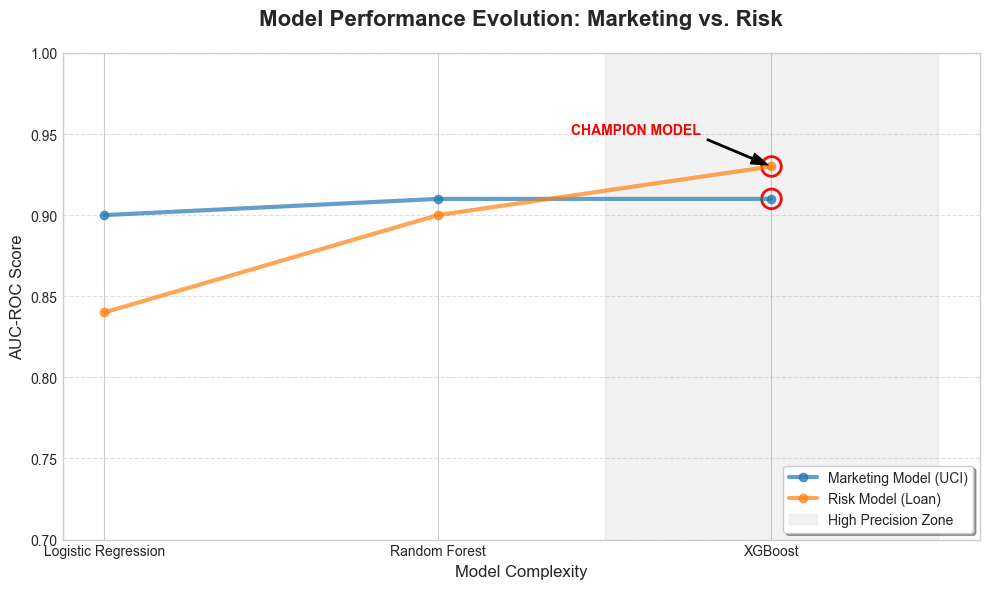

In [4]:
import matplotlib.pyplot as plt

# Data from your recap
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
marketing_auc = [0.90, 0.91, 0.91]
risk_auc = [0.84, 0.90, 0.93]

# Set up the plot
plt.figure(figsize=(10, 6), dpi=100)
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the lines
plt.plot(models, marketing_auc, marker='o', linewidth=3, color='#1f77b4', label='Marketing Model (UCI)', alpha=0.7)
plt.plot(models, risk_auc, marker='o', linewidth=3, color='#ff7f0e', label='Risk Model (Loan)', alpha=0.7)

# Highlight the XGBoost "Champion" points
plt.scatter(['XGBoost'], [0.91], s=200, facecolors='none', edgecolors='red', linewidths=2)
plt.scatter(['XGBoost'], [0.93], s=200, facecolors='none', edgecolors='red', linewidths=2)

# Add Annotation for "Champion Model"
plt.annotate('CHAMPION MODEL', xy=('XGBoost', 0.93), xytext=(1.4, 0.95),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, fontweight='bold', color='red')

# Formatting the chart
plt.title('Model Performance Evolution: Marketing vs. Risk', fontsize=16, pad=20, fontweight='bold')
plt.ylabel('AUC-ROC Score', fontsize=12)
plt.xlabel('Model Complexity', fontsize=12)
plt.ylim(0.70, 1.0) # Focus on the competitive range
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adding a shaded "Impact Zone" for the jury
plt.axvspan(1.5, 2.5, color='gray', alpha=0.1, label='High Precision Zone')

plt.legend(loc='lower right', frameon=True, shadow=True)
plt.tight_layout()

# Show plot
plt.show()